In [1]:
%matplotlib inline

#### 训练一个分类器

##### 关于数据

一般情况下处理图像，文本，音频和视频数据时，可以使用标准的Python包来加载数据到一个numpy数组中。然后把这个数组转换成`torch.*Tensor` 。

- 图像可以使用Pillow，OpenCV
- 音频可以使用scipy，librosa
- 文本可以使用原始Python和Cython来加载，或者使用NLTK或者SpaCy处理

特别的，对于图像任务，我们创建了一个包`torchvision`，它包含了处理一些基本图像数据集的方法。这些数据集包括Imagenet，CIFAR10，MINIST等。除了数据加载以外，`torchvision`还包含了图像转换器，`torchvision.datasets`和`torch.utils.data.DataLoader`。

##### 训练一个图像分类器
依次按照下列顺序进行：
1. 使用`torchvision`加载和归一化CIFAR10训练集和测试集
2. 定义一个卷积神经网络
3. 定义损失函数
4. 在训练集上训练网络
5. 在测试集上测试网络
6. 读取和归一化CIFAR10

使用`torchvision`可以非常容易地加载CIFAR10。

CIFAR-10的图像都是 3x32x32大小的，即，3颜色通道，32x32像素。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

`torchvision`的输出是[0,1]的PILImage图像，我们把它转换为归一化范围为[-1,1]的张量。

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
) # 定义一个转换器，将PIL图像转换为张量，并归一化

trainset = torchvision.datasets.CIFAR10(root='./data', train = True,
                                        download=True, transform=transform)  # 下载训练集

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4,
                                          shuffle = True, num_workers = 2)  # 创建训练集的数据加载器

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transform)  # 下载测试集

testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                         shuffle = False, num_workers = 2)  # 创建测试集的数据加载器

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # 定义类别名称

100.0%


我们展示一些训练图像。

  car ship frog ship


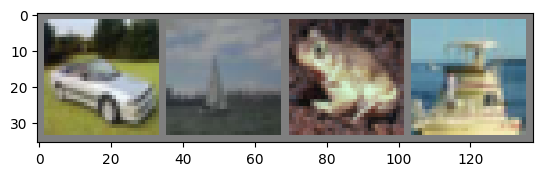

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 显示图像的函数
def imshow(img):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 获取一些随机训练图像
dataiter = iter(trainloader)
images, labels = next(dataiter) # 在 Python 3 中，迭代器对象不再有 .next() 方法。

# 显示图像
imshow(torchvision.utils.make_grid(images))

# 打印标签
print(''.join('%5s' % classes[labels[j]] for j in range(4))) 

2. 定义一个卷积神经网络

从之前的神经网络一节赋值神经网络代码，并修改为输入3通道图像。

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 输入通道数3，输出通道数6，卷积核大小5x5
        self.pool = nn.MaxPool2d(2, 2)  # 池化层，窗口大小2x2
        self.conv2 = nn.Conv2d(6, 16, 5) # 输入通道数6，输出通道数16，卷积核大小5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 全连接层，输入特征数16*5*5，输出特征数120
        self.fc2 = nn.Linear(120, 84)  # 全连接层，输入特征数120，输出特征数84
        self.fc3 = nn.Linear(84, 10)   # 全连接层，输入特征数84，输出特征数10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 卷积层1 + ReLU激活 + 池化
        x = self.pool(F.relu(self.conv2(x)))  # 卷积层2 + ReLU激活 + 池化
        x = x.view(-1, 16 * 5 * 5)            # 展平张量
        x = F.relu(self.fc1(x))               # 全连接层1 + ReLU激活
        x = F.relu(self.fc2(x))               # 全连接层2 + ReLU激活
        x = self.fc3(x)                       # 全连接层3
        return x

net = Net() 

3. 定义损失函数和优化器

我们使用交叉熵作为损失函数，使用带动量的随机梯度下降。

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 带动量的随机梯度下降优化器

4. 训练网络

我们只需要在数据迭代器上循环，将数据输入给网络，并优化。

In [9]:
for epoch in range(2):  # 遍历数据集两次

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data

        # 将梯度缓存清零
        optimizer.zero_grad()

        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000个小批量打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.229
[1,  4000] loss: 1.910
[1,  6000] loss: 1.708
[1,  8000] loss: 1.601
[1, 10000] loss: 1.515
[1, 12000] loss: 1.469
[2,  2000] loss: 1.393
[2,  4000] loss: 1.366
[2,  6000] loss: 1.346
[2,  8000] loss: 1.314
[2, 10000] loss: 1.305
[2, 12000] loss: 1.291
Finished Training


5. 在测试集上测试网络

我们在整个训练集上进行了2次训练，但是我们需要检查网络是否从数据集中学到有用的东西。通过预测神经网络输出的类别标签与实际情况标签进行对比来进行检测。如果预测正确，我们把该样本添加到正确预测列表。

第一步，显示测试集中的图片并熟悉图片内容。

GroundTruth:   cat ship shipplane


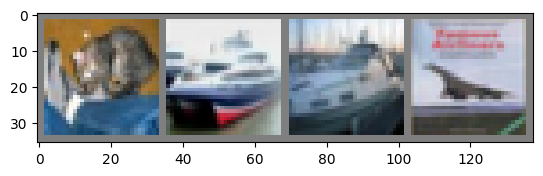

In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 显示测试图像
imshow(torchvision.utils.make_grid(images))
# 打印真实标签
print('GroundTruth:', ''.join('%5s' % classes[labels[j] ]for j in range(4)))

查看神经网络如何判定图像

In [12]:
outputs = net(images)

输出的是10个标签的能量。一个类别的能量越大，神经网络越认为它是这个类别。所以让我们得到最高能量的标签。

In [13]:
_, predicted = torch.max(outputs, 1) # 获取每行的最大值及其索引

print('Predicted:', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))  

Predicted:   cat  ship   car plane


接下来查看网络在测试集上的结果：

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 56 %


 在识别不同的类时的结果？

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data       # 获取数据
        outputs = net(images) # 获取网络输出
        _, predicted = torch.max(outputs, 1) # 获取预测结果
        c = (predicted == labels).squeeze() # 比较预测结果与真实标签
        for i in range(4):
            label = labels[i] # 获取真实标签
            class_correct[label] += c[i].item()     # 累加正确预测数
            class_total[label] += 1               # 累加总数


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 65 %
Accuracy of  bird : 46 %
Accuracy of   cat : 31 %
Accuracy of  deer : 38 %
Accuracy of   dog : 50 %
Accuracy of  frog : 73 %
Accuracy of horse : 72 %
Accuracy of  ship : 62 %
Accuracy of truck : 61 %


#### 在GPU上训练

这个操作会递归遍历所有模块，并将其参数和缓冲区转换为CUDA张量。

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


假定`device`是CUDA设备

然后将这些方法递归遍历所有模块并将模块的参数和缓冲区转换为CUDA张量

In [17]:
net.to(device)

# input, targets 和 images 也需要被转换到相同的设备上
inputs, labels = inputs.to(device), labels.to(device)

多GPU训练

参考下一节